# Apprentissage supervisé

## Travail Pratique 01 - Régression linéaire à une variable


<div class="alert alert-block alert-success">
<b>Informations générales </b>
</div>

**Professeur**: Stephan Robert

**Assistant(s)**: Arthur Babey

**Contact**: stephan.o.robert@gmail.com, arthur.babey@heig-vd.ch ou via Teams

**Rendu**:

- Date: 1 octobre 2024

- Modalité: Travail individuel. Une fois complétées et toutes les cellules exécutées, renommer le fichier en remplaçant Nom et Prenom par les votres "**TP1_APV_S1-2024_Reponses_Nom_Prenom.ipynb**" puis uploader votre fichier sur Cyberlearn.

- Note: Ce TP est noté sur 6, pour un poids de 12.5%

**Étudiant**:

- Julien Muhlemann

<div class="alert alert-block alert-success">
<b>But du TP </b>
</div>

Le but de ce premier TP est d'étudier la régression linéaire à une seule variable. 

<!---
<div class="alert alert-block alert-info">
<b>Rappel </b>
</div>
-->

<div class="alert alert-block alert-success">
<b>Table des matières </b>
</div>

1. Fonction Python simple

2. Régression linéaire à une variable
>* Visualisation des données
>* Loss function
>* Descente du gradient
3. Sensibilité aux valeurs abberantes
4. Gestion des valeurs abberantes
4. Anscombe's quartet

<div class="alert alert-block alert-success">
<b>Sources </b>
</div>

N'hésitez pas à utiliser des Cheat sheets et google pour (re)trouver rapidement certaines informations. Habituez vous aux sources fiables comme la documentation et les tutos officiels, puis migrez vers Stackoverflow pour les questions plus complexes. Si vous cherchez uniquement des informations sur la syntaxe, il n'y a pas besoin de citer vos sources. En revanche si vous trouvez des solutions complexes à certains problèmes, citez vos sources dans un commentaire dans le code par exemple. Cela vous permet d'éviter des accusations de plagiat et vous permet surtout de retrouver d'où viennent vos solutions. Néanmoins le but de ces petits exercices est de vous faire comprendre comment fonctionnent les algorithmes et à ce titre nous pensons qu'il est plus utile pour vous de passer du temps à programmer plutôt qu'à chercher des solutions toutes faites sur internet. 

## 1. Fonction Python simple

Commençons par importer les packages que nous allons utiliser plus tard.

In [41]:
import numpy as np
import pandas
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import cm
from sklearn.cluster import KMeans

En utilisant ces packages, il est très facile de faire de tracer des graphes. Par exemple

Text(0, 0.5, '$f(x) = e^{x}$')

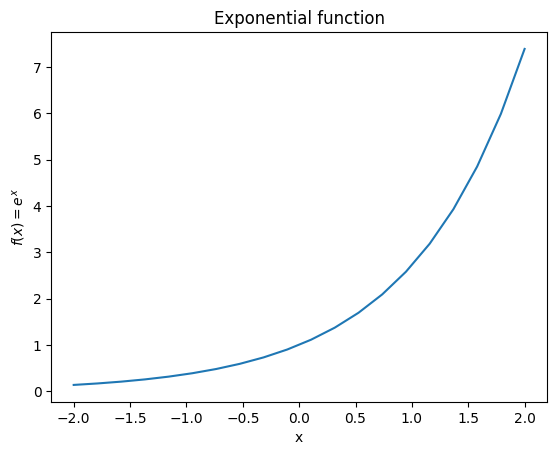

In [33]:
X = np.linspace(-2, 2, 20)
Y = np.exp(X)
plt.figure()
plt.plot(X, Y)
plt.title('Exponential function')
plt.xlabel('x')
plt.ylabel(r'$f(x) = e^{x}$')

## 2. Régression linéaire à une variable

Supposons que nous possédons une chaîne de food truck et que nous souhaitons ouvrir un food truck dans une nouvelle ville. Nous possédons l'historique du profit des food truck en fonction de la population de la ville. En utilisant ces données, nous souhaiterions décider du meilleur endroit pour implenter un nouveau food truck.

Le fichier ex1data1.txt contient les données que nous allons utiliser. La première colonne est la population de la ville et la deuxième le profit généré par le food truck de cette ville. Une valeur négative indique une perte.

### 2.1 Visualisation des données

Avant de commencer, nous allons visualiser les données.

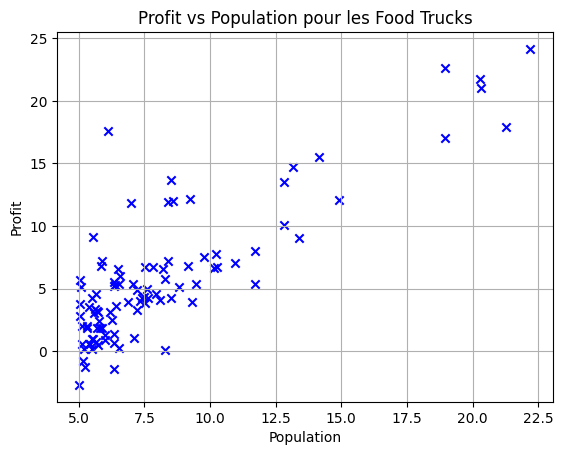

In [58]:
# TODO: tracer les données afin d'obtenir quelque chose qui ressemble à la figure ci-dessous
data = np.loadtxt('data.txt', delimiter=',', unpack=True)
X = data[0]
Y = data[1]

plt.figure()
plt.scatter(X, Y, color='blue', marker='x')
plt.xlabel('Population')
plt.ylabel('Profit')
plt.title('Profit vs Population pour les Food Trucks')
plt.grid(True)
plt.show()

### 2.2 Loss function

Rappelons que le but de la regression linéaire est de minimiser la fonction
$$
J(\mathbf{\Theta}) = J(\theta_{0}, \theta_{1}) = \frac{1}{2m}  \sum_{i=1}^{m} (f(x_{i}) - y_{i})^{2}
$$
où la fonction $f$ est de la forme $f(x) = \theta_{1}x + \theta_{0}$. Nous devons donc déterminer $\mathbf{\Theta}$ pour minimiser $J$. Afin de faire cela, nous pouvons utiliser la méthode du gradient.

Plus précisément, après avoir initialiser aléatoirement $\theta_{0}^{0}$ ainsi que $\theta_{1}^{0}$, on applique les itérations suivantes
\begin{equation}
\theta_{0}^{k} = \theta_{0}^{k-1} - \frac{\alpha}{m}\sum_{i=1}^{m} (\theta_{0}^{k-1} + \theta_{1}^{k-1}x_{i} - y_{i})
\end{equation}
ainsi que
\begin{equation}
\theta_{1}^{k} = \theta_{1}^{k-1} - \frac{\alpha}{m}\sum_{i=1}^{m} (\theta_{0}^{k-1} + \theta_{1}^{k-1}x_{i} - y_{i})x_{i}
\end{equation}

Nous allons maintenant implémenter cette loss fonction $J$ ainsi que l'interpolation linéaire $f$. Ces deux fonctions, nous seront utiles pour la suite de ce TP.

In [43]:
def linear_interpolation(x, theta):
     # TODO implémenter cette fonction. Theta est un vecteur de dimension 2.
    return theta[1] * x + theta[0]

In [44]:
def lossFunction(data, theta):
    """
    data: data points, data[0] are expected to be x, and data[1] y
    theta: value for theta (which is a vector of length 2)
    """
    # TODO : implémenter cette fonction
    X = data[0]
    Y = data[1]    
    total_error = np.sum((linear_interpolation(X, theta) - Y) ** 2)
    
    return (1 / (2 * len(X))) * total_error

Normalement, pour $\theta_{0} = \theta_{1} = 0$ et la loss fonction devrait retourner une valeur d'environ $32.072$

In [45]:
lossFunction(data, [0, 0])

32.072733877455676

### 2.3 Descent du gradient

Maintenan, nous allons implémenter le calcul du gradient en utilisant les équations présentées ci-dessus.

In [52]:
def gradientDescent(data, theta, alpha, epsilon):
    """
    points: data points, data[0] are expected to be the x, and data[1] the y
    theta: initial value for theta (which is a vector of length 2)
    alpha: learning rate
    epsilon: stopping criteria. We stop the training when the difference betwenn the new and the old theta 
    is smaller than epsilon.
    """
    # TODO: implémenter cette fonction
    X = data[0]
    Y = data[1]   
    theta_change = float('inf')
    
    while theta_change > epsilon:
        predictions = linear_interpolation(X, theta)
        errors = predictions - Y
        
        gradient_0 = (1 / m) * np.sum(errors)
        gradient_1 = (1 / m) * np.sum(errors * X)
        
        new_theta_0 = theta[0] - alpha * gradient_0
        new_theta_1 = theta[1] - alpha * gradient_1
        new_theta = [new_theta_0, new_theta_1]
        
        theta_change = np.linalg.norm(np.array(new_theta) - np.array(theta)) #différence entre les deux vecteurs (dist. euclidienne)
        theta = new_theta
        
    return theta


En utilisant cett fonction, nous pouvons donc déterminer un $\Theta_{\text{opt}}$, qui, espérons-le, sera optimal. (Rappelons que la descente du gradient n'a pas de gurarantie de convergence).

In [54]:
alpha = 0.0001
epsilon = 1e-5
theta_0 = [0, 0]
theta_opt = gradientDescent(data, theta_0, alpha, epsilon)
print('The computed theta we found is ', theta_opt)

The computed theta we found is  [-3.3438230256507437, 1.1375834909031446]


Maintenant, en utilisant ce paramètre $\Theta_{\text{opt}}$, nous allons tracer notre régression linéaire.

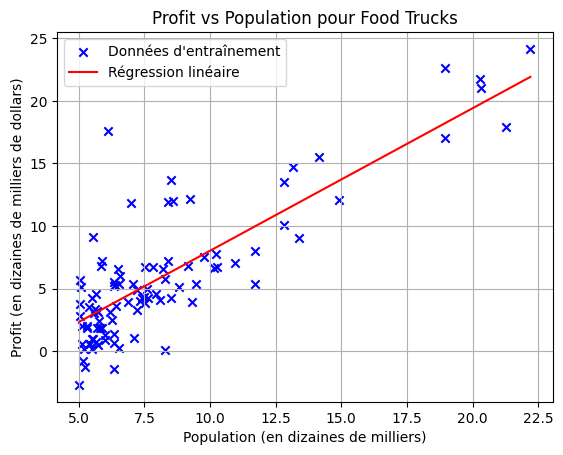

In [65]:
# TODO: faire un plot des données d'entraînement ainsi que de la régression linéaire qui minimise la loss fonction
# normalement vous devriez trouver quelque chose qui ressemble à la figure ci-dessous.

def print_plot(X, Y, theta_opt):
    plt.figure()
    plt.scatter(X, Y, color='blue', marker='x', label='Données d\'entraînement')
    
    x_values = np.linspace(min(X), max(X), 100)
    y_values = theta_opt[1] * x_values + theta_opt[0]
    plt.plot(x_values, y_values, color='red', label='Régression linéaire')
    
    plt.xlabel('Population (en dizaines de milliers)')
    plt.ylabel('Profit (en dizaines de milliers de dollars)')
    plt.title('Profit vs Population pour Food Trucks')
    plt.grid(True)
    plt.legend()
    
    plt.show()

print_plot(X, Y, theta_opt)


## 3. Sensibilité aux valeurs aberrantes

Supposons maintenant qu'il y a eu quelques erreurs et qu'on a accidentellement rajouté un profit de $100$ aux $10$ premières données. 

In [64]:
data = np.loadtxt('data.txt', delimiter=',', unpack=True)

data_y = data[1]
data_y[:10] = data_y[:10] + 100
data_with_outliers = [data[0], data_y]

Pour comprendre ce qui a changé, il est toujours utile de visualiser les données.

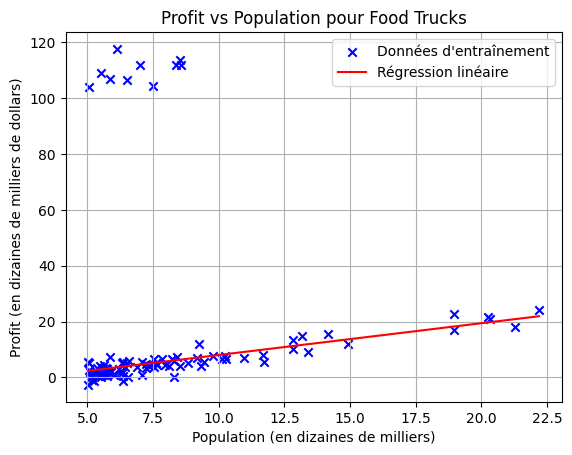

In [66]:
# TODO: comme avant, faire un plot de ces nouvelles données.
print_plot(data_with_outliers[0], data_with_outliers[1], theta_opt)

Ensuite et comme avant, on peut déterminer un $\Theta_{\text{opt}}$ pour ce nouveaux dataset et tracer la regression qui en découle.

In [67]:
alpha = 0.0001
epsilon = 1e-5
theta_0 = [0, 0]
theta_opt = gradientDescent(data_with_outliers, theta_0, alpha, epsilon)

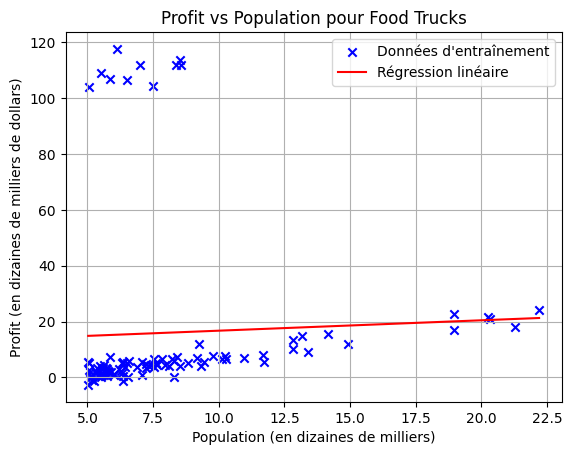

In [68]:
# TODO: faire un plot des données ainsi que de la regression linéaire

alpha = 0.0001
epsilon = 1e-5
theta_0 = [0, 0]
theta_opt = gradientDescent(data_no_ou, theta_0, alpha, epsilon)

print_plot(data_with_outliers[0], data_with_outliers[1], theta_opt)

Et si on trace notre régression linéaire en ne tenant pas compte des valeurs aberrantes.

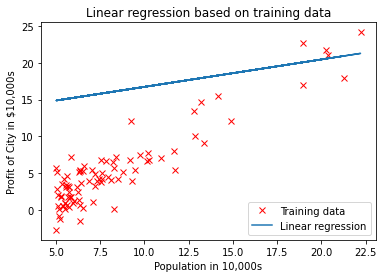

In [14]:
# TODO: tracer le même graphe que ci-dessus mais sans tenir compte des valeurs aberrantes
data = np.loadtxt('data.txt', delimiter=',', unpack=True)
alpha = 0.0001
epsilon = 1e-5
theta_0 = [0, 0]
theta_opt = gradientDescent(data_with_outliers, theta_0, alpha, epsilon)

Comme vous pouvez l'observer en comparant cette figure et la figure obtenue à l'exercice, notre modèle a été perturbé par l'ajouts de ces quelques valeurs aberrantes. D'un point de vue, théorique cela est assez clair. Sauriez-vous expliquer pourquoi?

## 4. Gestion des valeurs aberrantes

Dans notre situation, et comme nous travaillons dans un espace à deux dimensions nous pouvons juste faire un plot des données et il sera évident que notre jeux de donnée contient des valeurs aberrantes. Mais de manière générale il n'est pas possible de faire cela.

Plus généralement, une approche pour essayer de déterminer si le dataset contient des données abberrantes consisite à utiliser un algorithme de clustering, comme par exemple k-mean.  Nous allons donc faire cela en utilisant deux clusters.

In [ ]:
# TODO: utiliser KMeans de scikit avec n_clusters=2 afin de séparer les données contenants les outilers 
# (i.e. data_with_outliers) en deux groupes

Après avois déterminer ces deux clusters, nous allons les représenter graphiquement pour voir ce que nous avons trouvé.

Text(0, 0.5, 'Profit of City in 10,000s')

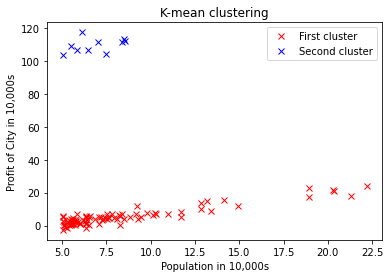

In [18]:
# TODO: faire un plot de ces deux clusters

Sans surprise, nous avons trouvé les deux clusters trouvés par k-mean séparent les valeurs aberrantes des autres. En étudiant plus précisément les données obtenus dans chaque cluster, nous pourrions nous rendre compte que les valeurs contenues dans le premier cluster correspond à des valeurs aberrantes. Nous pourrions alors décider de ne pas pas prendre compte de ces valeurs et construire une régression linéaire comme au point $2$ de ce TP.

Supposons maintenant que les données présentes dans les deux premiers clusters ne sont pas des données aberrantes. Nous observons deux cluster clairement séparés car ils correspondent à deux groupes de populations avec des différences bien spécifiques. Par exemple correspondant à deux pays différents. Dans cette situation, il serait sans doute plus pertinent de construire deux régressions linéaire différentes: une pour chaque cluster. C'est ce que nous allons faire maintenant.

In [1]:
# TODO: calculer les paramètres optimaux de la régression linéaire sur le premier cluster

In [2]:
# TODO: calculer les paramètres optimaux de la régression linéaire sur le deuxième cluster

Finallement, nous allons tracer les régressions obtenues.

Text(0, 0.5, 'Profit of City in 10,000s')

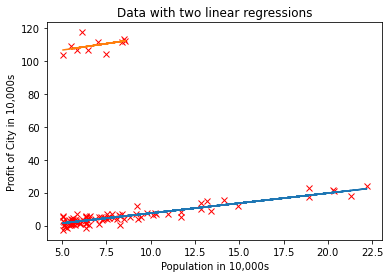

In [218]:
# TODO: tracer les régressions linéaires obtenues

## 4. Anscombe's quartet

Pour finir, nous allons illustrer les limitations de la régression par un exemple bien connu. Considérons les datasets suivants, appelé, 'Anscombe's quartet'.

In [219]:
x = np.array([10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5])
y1 = np.array([8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68])
y2 = np.array([9.14, 8.14, 8.74, 8.77, 9.26, 8.10, 6.13, 3.10, 9.13, 7.26, 4.74])
y3 = np.array([7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73])
x4 = np.array([8, 8, 8, 8, 8, 8, 8, 19, 8, 8, 8])
y4 = np.array([6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.50, 5.56, 7.91, 6.89])

datasets = {
    'I': [x, y1],
    'II': [x, y2],
    'III': [x, y3],
    'IV': [x4, y4]
}

Pour commencer, et comme d'habitude, visualisons ces données.

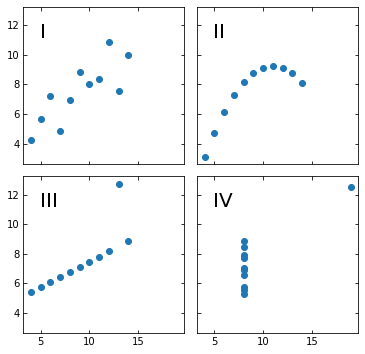

In [220]:
# TODO: faire un plot des données

Maintenat, en utilisant nos fonctions, faites une régression linéaire pour chaque dataset.

In [3]:
# TODO: calculer la régression linéaire qui minimise notre loss function pour chaque dataset du dictionaire datasets.

Et finalement, on peut tracer ces régressions linéaire ainsi que les datasets.

In [ ]:
# TODO: tracer les données ainsi que les régression linéaires calculées ci-dessus.